In [1]:
from fairseq.models.roberta import RobertaModel

import sys
sys.path.append('../..')
from go_annotation import fairseq_layers

In [2]:
roberta = RobertaModel.from_pretrained('/gpfs/alpine/scratch/pstjohn/bie108/fairseq-uniparc/122820_go_swissprot_finetune/',
                                       data_name_or_path='/ccs/home/pstjohn/project_work/swissprot_go_annotation/fairseq_swissprot/',
                                       checkpoint_file='checkpoint_best.pt')

_ = roberta.eval()  # disable dropout (or leave in train mode to finetune)

In [4]:
import torch

from go_annotation.ontology import Ontology
ont = Ontology()

_ancestor_array = ont.ancestor_array()

def normalize_logits(logits):
    bsz = logits.shape[0]
    index_tensor = logits.new_tensor(_ancestor_array, dtype=torch.int64)
    index_tensor = index_tensor.unsqueeze(0).expand((bsz, -1, -1))  # Array of ancestors, offset by one
    padded_logits = torch.nn.functional.pad(logits, (1, 0), value=float('inf'))  # Make 0 index return inf
    padded_logits = padded_logits.unsqueeze(-1).expand((-1, -1, index_tensor.shape[2]))
    normed_logits = torch.gather(padded_logits, 1, index_tensor)
    normed_logits, _ = torch.min(normed_logits, -1)
    
    return normed_logits

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_ = roberta.to(device)

In [12]:
def encode(sequence):
    return roberta.task.source_dictionary.encode_line(sequence)

In [49]:
from itertools import islice
import numpy as np
from scipy.sparse import load_npz

def inputs_generator(filename):
    batch_size = 4
    with open(filename, 'r') as f:
        encoded_lines = (encode(line) for line in f)   
        for batch in iter(lambda: tuple(islice(encoded_lines, batch_size)), ()):
            yield data_utils.collate_tokens(
                batch, pad_idx=roberta.task.source_dictionary.pad()).long().to(device)

def targets_generator(filename):
    y_true_test = load_npz(filename)
    dense_rows = (np.asarray(row.todense()) for row in y_true_test)
    for batch in iter(lambda: tuple(islice(dense_rows, batch_size)), ()):
        yield np.vstack(batch)
            
inputs_filename = '/ccs/home/pstjohn/project_work/swissprot_go_annotation/fairseq_swissprot_debug/input0/test.raw'
targets_filename = '/ccs/home/pstjohn/project_work/swissprot_go_annotation/fairseq_swissprot_debug/label/test.npz'

In [57]:
from sklearn.metrics import precision_recall_curve

for inputs, targets in zip(inputs_generator(inputs_filename), targets_generator(targets_filename)):
    
    with torch.no_grad():
        logits, _ = roberta.model(inputs,
                                  features_only=True,
                                  classification_head_name='go_prediction')
        
        normed_logits = normalize_logits(logits)
        batch_pred = torch.sigmoid(normed_logits)    
    
    break

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [67]:
precision, recall, thresholds = precision_recall_curve(targets.flatten(), batch_pred.detach().cpu().numpy().flatten())

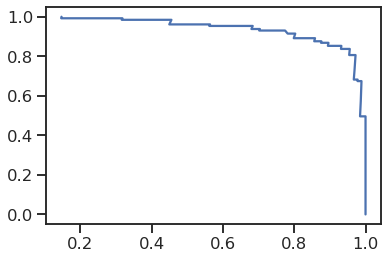

In [69]:
plt.plot(precision, recall)

In [63]:
.shape

(4, 32012)

In [18]:
from fairseq.data import data_utils

tensor([[20, 19,  4,  ...,  8, 19,  2],
        [ 5, 16, 13,  ...,  1,  1,  1],
        [20, 16, 14,  ...,  1,  1,  1],
        [20,  5, 15,  ...,  1,  1,  1]], dtype=torch.int32)

In [17]:
torch.stack(batch)

RuntimeError: stack expects each tensor to be equal size, but got [408] at entry 0 and [166] at entry 1